In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [8]:
# Paths to dataset
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = '/content/drive/MyDrive/VGG19/DATA'
categories = ['Healthy', 'Sick']
img_size = (224, 224)



In [10]:
# Load and preprocess
data, labels = load_dataset(data_dir, img_size)
data = preprocess_data(data, img_size)


In [11]:
# Step 1: Load the dataset
def load_dataset(data_dir, img_size=(224, 224)):
    """
    Load images from the Sick and Healthy folders.
    """
    categories = ["Healthy", "Sick"]
    data = []
    labels = []
    for category in categories:
        folder_path = os.path.join(data_dir, category)
        label = categories.index(category)
        for img_file in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                roi = find_roi(img)  # Extract the ROI
                img_resized = cv2.resize(roi, img_size)  # Resize ROI to model input size
                data.append(img_resized)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")
    return np.array(data), np.array(labels)

In [12]:
# Step 2: Find ROI (Region of Interest)
def find_roi(image):
    """
    Detect and extract the Region of Interest (ROI) in a thermal image.
    """
    # Normalize the image
    normalized_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Apply thresholding to highlight warm regions
    _, thresh = cv2.threshold(normalized_img, 50, 255, cv2.THRESH_BINARY)

    # Find contours of the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If contours are found, extract the largest one (assumes ROI is the largest object)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = image[y:y+h, x:x+w]  # Crop the ROI
    else:
        roi = image  # If no contours, return the original image as fallback

    return roi


In [13]:
# Step 3: Preprocess the dataset
def preprocess_data(data, img_size=(224, 224)):
    """
    Preprocess data: Normalize and convert to 3 channels for VGG19.
    """
    data = data / 255.0  # Normalize pixel values
    data = np.expand_dims(data, axis=-1)  # Add channel dimension
    data = np.repeat(data, 3, axis=-1)  # Repeat channel to convert grayscale to RGB
    return data

In [14]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [15]:
# Step 4: Define the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the full model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: Healthy and Sick
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Step 5: Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Train the model
batch_size = 32
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)

In [17]:
# Step 6: Train the model
history = model.fit(train_gen, epochs=10, validation_data=(X_test, y_test))

# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 773s 31s/step - accuracy: 0.6037 - loss: 0.8019 - val_accuracy: 0.7400 - val_loss: 0.5564
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 716s 29s/step - accuracy: 0.7520 - loss: 0.5407 - val_accuracy: 0.7450 - val_loss: 0.5026
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 736s 29s/step - accuracy: 0.7594 - loss: 0.5348 - val_accuracy: 0.7700 - val_loss: 0.4901
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 714s 29s/step - accuracy: 0.7773 - loss: 0.4817 - val_accuracy: 0.7650 - val_loss: 0.4786
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 742s 29s/step - accuracy: 0.7912 - loss: 0.4699 - val_accuracy: 0.7650 - val_loss: 0.4855
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 737s 28s/step - accuracy: 0.7637 - loss: 0.5010 - val_accuracy: 0.7700 - val_loss: 0.4715
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 714s 29s/step - accuracy: 0.7729 - loss: 0.4819 - val_accuracy: 0.7800 - val_loss: 0.4821
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 740s 29s/step - accuracy: 0.7772 - loss: 0.4704 - val_accuracy: 0.7700 - val_

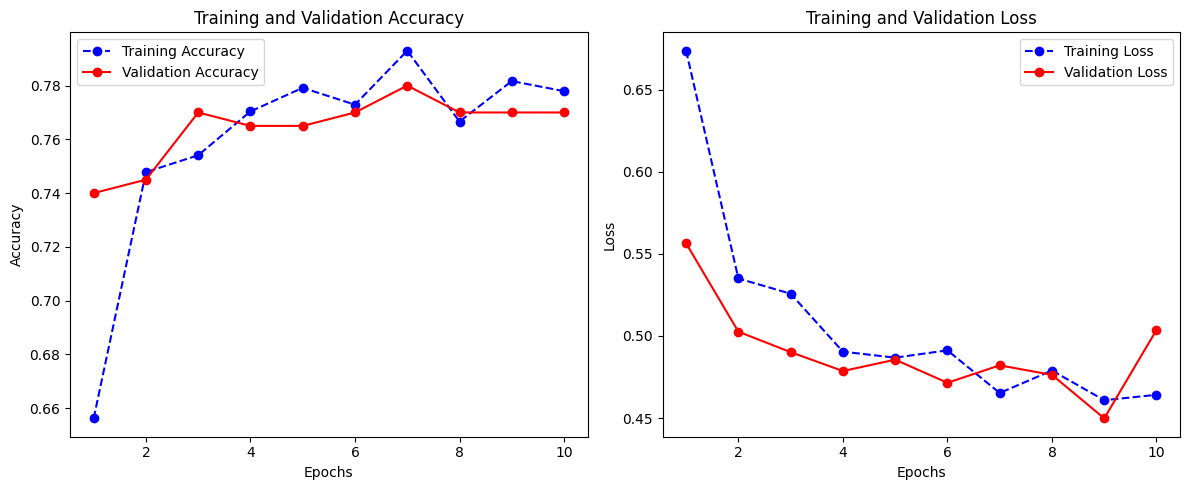

In [18]:
# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss from the training history.
    """
    # Extract values from the history object
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='--', color='b')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-', color='r')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='--', color='b')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-', color='r')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your training history
plot_training_history(history)
